<a href="https://colab.research.google.com/github/DrAlexSanz/MC-calculations/blob/main/Monte_Carlo_SP500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
from pandas_datareader import data as wb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm



# Download SP500 data 

First of all, download all the data since 1980. It goes back to 1927 or so but I'll restrict it to 1980. Maybe I'll do a run with the full data later.

In [2]:
data = pd.DataFrame()

ticker = "^GSPC" #This is the ticker of the SP500 according to Yahoo Finance.
start_dt = "1980-01-01"
end_dt = "2020-12-31"

data = wb.DataReader(ticker, start = start_dt, end = end_dt, data_source = "yahoo") #The date is the index

# Now I have the full data, let's keep the adjusted close and see the time limits
data = data[["Adj Close"]]

data.reset_index(inplace = True) # I don't like to have the date as an index, I want normal index and date as a column
print(data.head())


        Date   Adj Close
0 1980-01-02  105.760002
1 1980-01-03  105.220001
2 1980-01-04  106.519997
3 1980-01-07  106.809998
4 1980-01-08  108.949997


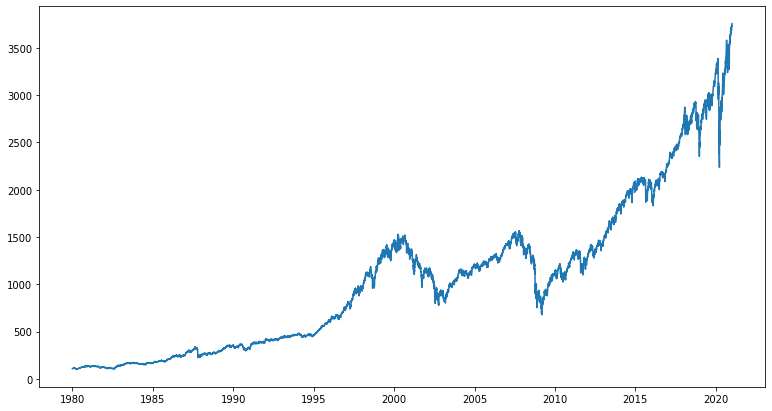

In [3]:
plt.figure(figsize = (13, 7))
plt.plot(data["Date"], data["Adj Close"])
plt.show()

With this I can calculate the CAGR manually, see what happened.

The formula is:

$$
  C = C_0 \cdot (1 + x)^n
$$

And I solve for x when n is 40 periods (1980 to 2020). It should be close to 8-10%

In [4]:
C_0 = data.iloc[1]["Adj Close"]
C = data.iloc[-1]["Adj Close"]

x = (C/C_0)**(1/40) - 1

print(round(x, 2))

0.09


And it is 9% without taking inflation into account. Not bad!

## Now what I want to do is to start the Montecarlo part.

I am going to do it using daily returns and iterating daily. I will do the yearly version later.

In [5]:
day_return = data["Adj Close"].pct_change() # And this is a Series

day_return # Obviously the first one is NaN. There is no % growth before the first day.

0             NaN
1       -0.005106
2        0.012355
3        0.002723
4        0.020036
           ...   
10335    0.003537
10336    0.008723
10337   -0.002227
10338    0.001342
10339    0.006439
Name: Adj Close, Length: 10340, dtype: float64

First, let's check the basic info and see if I have nulls

In [6]:
day_return.describe()

count    10339.000000
mean         0.000410
std          0.011313
min         -0.204669
25%         -0.004496
50%          0.000575
75%          0.005689
max          0.115800
Name: Adj Close, dtype: float64

In [7]:
#Looks like I have Nulls

print(np.isnan(day_return).value_counts())
day_return = day_return.dropna()

False    10339
True         1
Name: Adj Close, dtype: int64


Text(0.5, 1.0, 'Distribution of daily returns')

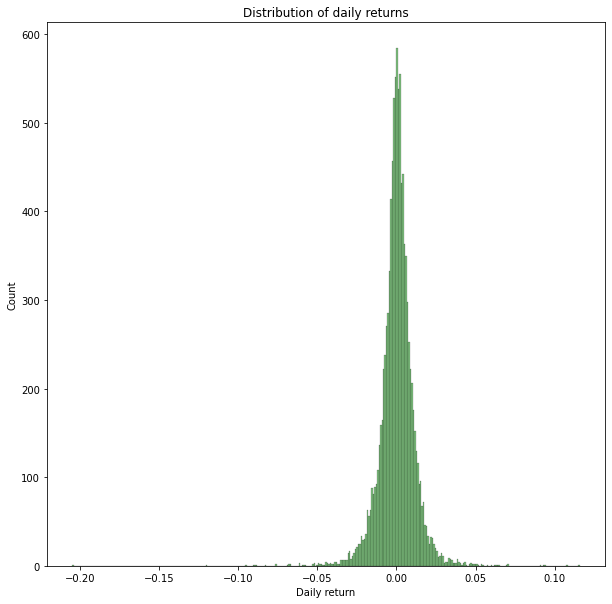

In [8]:
#mu, std = norm.fit(day_return)

#print("The daily returns follow a Normal distribution with \mu = {mu:.3f} and standard deviation = {std:.3f}")

plt.figure(figsize = (10, 10))
sns.histplot(day_return, color = "green", alpha = 0.5)
plt.xlabel("Daily return")
plt.ylabel("Count")
plt.title("Distribution of daily returns") # Being more than 10,000 days I expect a fairly Normal distribution

I can fit it to a Normal distribution because now sns.histplot doesn't do it.

In [9]:
mu, std = norm.fit(day_return)
print(mu, std)

0.00040976599455143863 0.01131231818950601


The daily returns will have a small average and a std fairly larger. It's not usual to have a big daily return, yearly it's compounding but not every day.

## Log returns.

I don't want to use returns in general, but mostly the log of the returns. According to literature this is a good idea for several reasons. See [Explanation of why log returns.](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)

Especially I want to use log(1 + x) because it's normal and fulfills all the assumptions.

Text(0.5, 1.0, 'Distribution of daily returns')

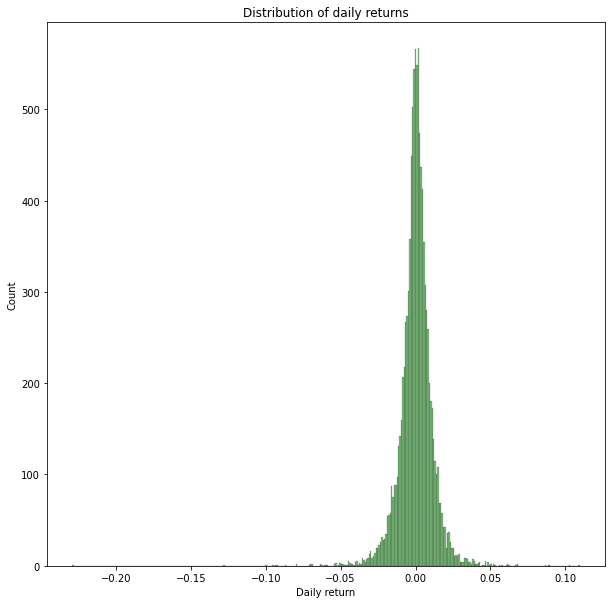

In [10]:
log_ret = np.log(1 + day_return)

plt.figure(figsize = (10, 10))
sns.histplot(log_ret, color = "green", alpha = 0.5)
plt.xlabel("Daily return")
plt.ylabel("Count")
plt.title("Distribution of daily returns") # Being more than 10,000 days I expect a fairly Normal distribution

So the plot looks the same but how about the $\mu$ and $\sigma$?

They will be the same because of the following sorcery:

$$ln(1 + x) \approx x; \space \forall x << 1$$

This is the Taylor (MacLaurin) series:

$$ln(1 + x) = x - \frac{x^2}{2} + \frac{x^3}{3} - \frac{x^4}{4} + ...$$

And I can neglect the higher order terms. When I'm doing the daily returns it doesn't really matter but when I will do the yearly version it will.

In [11]:
mu_log, std_log = norm.fit(day_return)
print(mu_log, std_log)

0.00040976599455143863 0.01131231818950601


Anyway, let's go into the equations

$$Drift = \mu - \frac{\sigma^2}{2}$$

$$Volatility = \sigma \cdot \mathcal{N(0, 1)}$$

$$r = Drift - Volatility $$

$$S_t = S_{t-1}\cdot e^{(\mu - \frac{\sigma}{2}) + \sigma \cdot \mathcal{N(0, 1)}}$$

The $\frac{1}{2}$ in the Drift is because past returns are eroded in the future. The volatility is the historical volatility multiplied by a Normal distribution. Like Gaussian beams in LHC.

In [201]:
u = day_return.mean()
var = day_return.var()

stdev = day_return.std()

days = 20*12*30 # 30 years or so
iterations = 1500

drift = u - 0.5 * var**2

random_returns = norm.ppf(np.random.rand(iterations, days)) # So this is doing one day per column, one iteration per row

future_returns = np.exp(drift + stdev * random_returns)




In [202]:
# And now generate the curves

curves = np.zeros_like(future_returns)

curves[:, 0] = data.iloc[-1]["Adj Close"] # Starting day is the last day of the data

In [203]:
#Nested loops go brrr

for t in range(0, iterations):
    for d in range(1, days):
      curves[t, d] = curves[t, d-1] * future_returns[t, d]

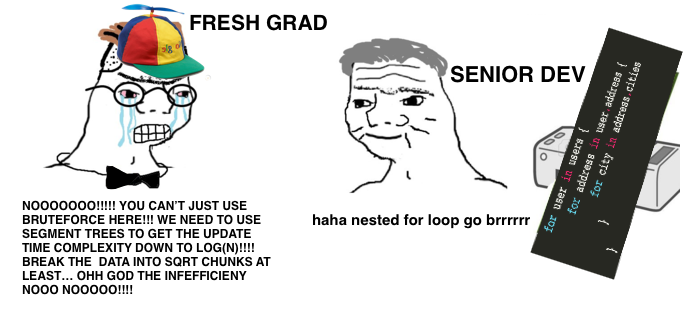

Now, it is possible to plot all of them but this is going to take time, so I'll plot only the first 20

In [204]:
to_plot = curves[:20, :]
to_plot.shape # So this takes the first 20 iterations for 30 days

(20, 7200)

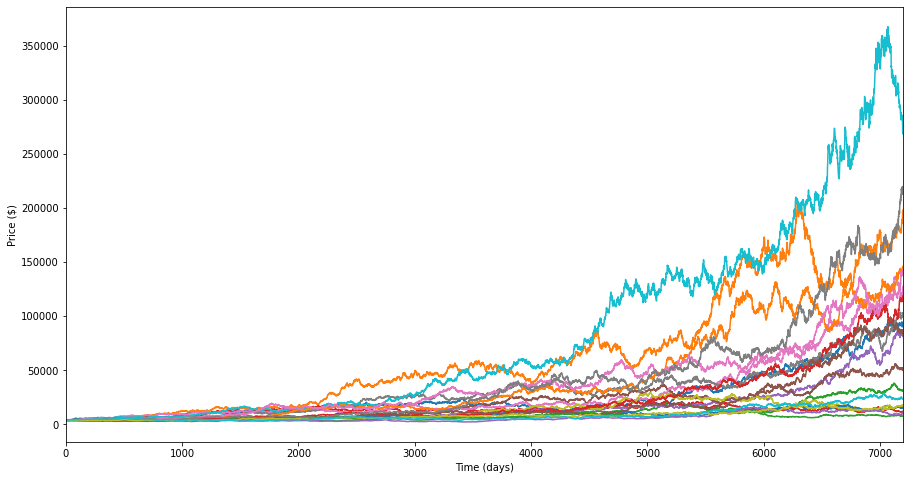

In [205]:
plt.figure(figsize=(15,8))
plt.xlim([0, to_plot.shape[1] - 1]) # Set axes limits
plt.xlabel("Time (days)")
plt.ylabel("Price ($)")
for col in range(to_plot.shape[0]):
  plt.plot(to_plot[col, :]);

Nice plots bro! But now let's see in which cases we got a nice return. I'll only take the first and last day because this is intending to simulate a hold portfolio.

In [206]:
two_cols = np.array([curves[:, 0], curves[:, -1]]).transpose()

first_last = pd.DataFrame(two_cols, columns = ["First day", "Last day"])

#And let's check that it's the correct values and shape
first_last.head()

,First day,Last day
0,3756.070068,94269.443540
1,3756.070068,198005.863701
2,3756.070068,31274.410628
3,3756.070068,12055.114649
4,3756.070068,81109.457968


Let's take a look at the distribution of results

In [207]:
first_last.describe()

,First day,Last day
count,1500.000000,1.500000e+03
mean,3756.070068,1.081744e+05
std,0.000000,1.425959e+05
min,3756.070068,3.812929e+03
25%,3756.070068,3.752025e+04
50%,3756.070068,7.051122e+04
75%,3756.070068,1.333322e+05
max,3756.070068,3.090520e+06


Let's calculate the CAGR as a % to see what it looks like. It should be reasonable, around 10%.

In [209]:
first_last["CAGR"] = ((first_last["Last day"] / first_last["First day"])**(1/(39)) - 1 ) * 100 # It's 39 periods, 40 years.
first_last["CAGR"] = first_last["CAGR"].round(1)
first_last.head()

,First day,Last day,CAGR
0,3756.070068,94269.443540,8.6
1,3756.070068,198005.863701,10.7
2,3756.070068,31274.410628,5.6
3,3756.070068,12055.114649,3.0
4,3756.070068,81109.457968,8.2


And let's have a quick look at the distribution of the scenarios:

In [210]:
first_last.describe()

,First day,Last day,CAGR
count,1500.000000,1.500000e+03,1500.000000
mean,3756.070068,1.081744e+05,7.821467
std,0.000000,1.425959e+05,2.563141
min,3756.070068,3.812929e+03,0.000000
25%,3756.070068,3.752025e+04,6.100000
50%,3756.070068,7.051122e+04,7.800000
75%,3756.070068,1.333322e+05,9.600000
max,3756.070068,3.090520e+06,18.800000


# Conclusions

1.   Nice exercise, quite simple but cool.
2.   [SP500 go brrr!!](https://brrr.money/)
3.   My numbers are as good as my data and my assumptions. I assumed a lot of things, so don't take it too seriously. However I still got a good 40 years of data, not too bad.
4.   I'm assuming each day is independent from the other ones but there should be streaks as the economy gains momentum, either upwards or downwards. However doing it by day, independence is not too bad of an assumption.
5.   Since my average daily return is about 0.04%, compounding over 30 years that result in a 18x approx. Obviously almost no scenario will finish below the starting point. The minimum can be below 0% CAGR but the 25% percentile will be relatively high.
6.   If I do it by year I believe this would result in a more coarser version of this scenario. It's basically a way for me to reduce my available/necessary data but it should result in a similar distribution I believe.
7.   If I take a window of fewer years and one of the scenarios, the likelihood of losing money increases.
8.   Past performance doesn't guarantee anything.
9.   Put it all in dogecoins ;)

